
## Dimensionality reduction

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from astroML.datasets import sdss_corrected_spectra
import seaborn as sns

from sklearn.manifold import LocallyLinearEmbedding, Isomap, SpectralEmbedding

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn import manifold, neighbors

from scipy.sparse.csgraph import laplacian as csgraph_laplacian
import scipy.spatial as spt
from scipy.sparse.linalg import eigsh, eigs

from umap import UMAP

from collections import OrderedDict
from time import time
from matplotlib.ticker import NullFormatter
import pandas as pd
import random


random_state = 42
np.random.seed(random_state)

#### Application of PCA

For our astronomy use case, we are using the SDSS spectroscopic dataset. 
The SDSS spectra come from galaxies at a range of redshifts,
and have sections of unreliable or missing data due to sky absorption, cosmic rays, bad detector pixels,
or other effects. AstroML provides a set of spectra which have been moved to rest frame, corrected
for masking using an iterative PCA reconstruction technique, and resampled to 1000 common wavelength bins. 

The spectra can be downloaded using `fetch_sdss_corrected_spectra()`. In the following example we plot
15 of these spectra:

In [2]:
data = sdss_corrected_spectra.fetch_sdss_corrected_spectra()
spectra = sdss_corrected_spectra.reconstruct_spectra(data)
y = data['lineindex_cln']

# lookup for classes, 0-6
cdict = ['unknown', 'star', 'absorption galaxy',
         'galaxy', 'emission galaxy',
         'narrow-line QSO', 'broad-line QSO']


In [3]:

#----------------------------------------------------------------------
# Use pre-computed PCA to reconstruct spectra
spectra_raw = data['spectra']
spectra_corr = sdss_corrected_spectra.reconstruct_spectra(data)
wavelengths = sdss_corrected_spectra.compute_wavelengths(data)

#------------------------------------------------------------
# select random spectra
nrows = 5
ncols = 3
ind = np.random.randint(spectra_corr.shape[0], size=nrows * ncols)
spec_sample_raw = spectra_raw[ind]
spec_sample_corr = spectra_corr[ind]

We show the SDSS downloaded spectra with black, and our corrected spectra with blue.

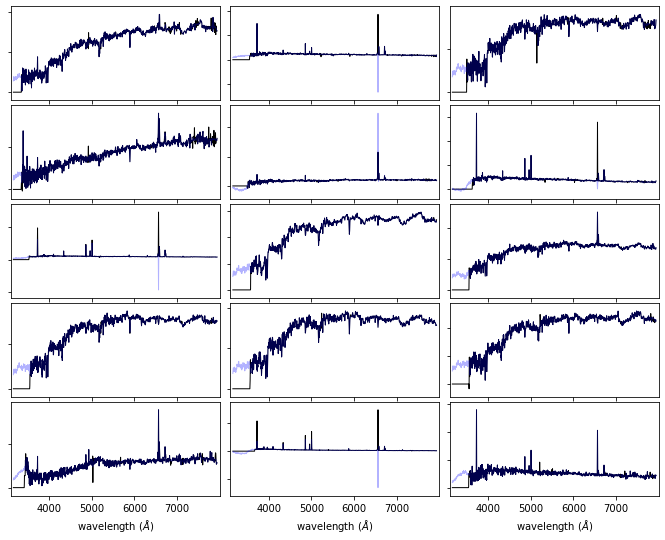

In [4]:
fig = plt.figure(figsize=(10, 8))

fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05,
                    bottom=0.1, top=0.95, hspace=0.05)

for i in range(ncols):
    for j in range(nrows):
        ax = fig.add_subplot(nrows, ncols, ncols * j + 1 + i)
        ax.plot(wavelengths, spec_sample_raw[ncols * j + i], '-k', lw=1)
        ax.plot(wavelengths, spec_sample_corr[ncols * j + i], '-b', lw=1, alpha=0.3) # , c='blue')               
        ax.set_xlim(3100, 7999)

        ax.yaxis.set_major_formatter(plt.NullFormatter())
        ax.xaxis.set_major_locator(plt.MultipleLocator(1000))
        if j < nrows - 1:
            ax.xaxis.set_major_formatter(plt.NullFormatter())
        else:
            plt.xlabel(r'wavelength $(\AA)$')

        ylim = ax.get_ylim()
        dy = 0.05 * (ylim[1] - ylim[0])
        ax.set_ylim(ylim[0] - dy, ylim[1] + dy)

plt.show()

### PCA Reconstruction of a spectrum

Reconstruction of spectrum, ${x}(k)$, from the
eigenvectors, ${e}_i(k)$ 

$$  {x}_i(k) = {\mu}(k) + \sum_j^R \theta_{ij} {e}_j(k),$$

Truncating this expansion (i.e., $r<R$)

$$
{x}_i(k) = {\mu}(k) + \sum_i^{r<R} \theta_i {e}_i(k),
$$

- eigenvectors ordered by their associated eigenvalues 
- eigenvalues reflect variance  within each eigenvector (sum of the eigenvalues is total variance of the system).
- project a each spectrum onto these first few eigenspectra is a compression of the data 

This is the sense in which PCA gives for dimensionality reduction.

In the following example, the input spectrum is shown in gray,
and the partial reconstruction for progressively more terms is shown in black. 
The top panel shows only the mean of the set of spectra. By the time 20 PCA components are added,
the reconstruction is very close to the input, as indicated by the expected total variance of 94%.

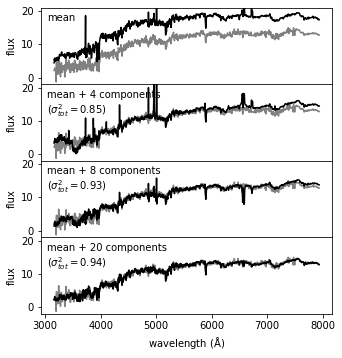

In [5]:
#------------------------------------------------------------
# Compute PCA components
#  because the spectra have been reconstructed from masked values, 
#  we'll use the values computed
#  in the file compute_sdss_pca.py
evals = data['evals'] ** 2
evals_cs = evals.cumsum()
evals_cs /= evals_cs[-1]
evecs = data['evecs']
spec_mean = spectra_corr.mean(0)

#------------------------------------------------------------
# Find the coefficients of a particular spectrum
spec = spectra_corr[1]
coeff = np.dot(evecs, spec - spec_mean)

#------------------------------------------------------------
# Plot the sequence of reconstructions
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(hspace=0, top=0.95, bottom=0.1, left=0.12, right=0.93)

for i, n in enumerate([0, 4, 8, 20]):
    ax = fig.add_subplot(411 + i)
    ax.plot(wavelengths, spec, '-', c='gray')
    ax.plot(wavelengths, spec_mean + np.dot(coeff[:n], evecs[:n]), '-k')

    if i < 3:
        ax.xaxis.set_major_formatter(plt.NullFormatter())

    ax.set_ylim(-2, 21)
    ax.set_ylabel('flux')

    if n == 0:
        text = "mean"
    elif n == 1:
        text = "mean + 1 component\n"
        text += r"$(\sigma^2_{tot} = %.2f)$" % evals_cs[n - 1]
    else:
        text = "mean + %i components\n" % n
        text += r"$(\sigma^2_{tot} = %.2f)$" % evals_cs[n - 1]

    ax.text(0.02, 0.93, text, ha='left', va='top', transform=ax.transAxes)

fig.axes[-1].set_xlabel(r'${\rm wavelength\ (\AA)}$')
plt.show()

### Eigenvalues

The eigenvalues for the PCA decomposition of the SDSS spectra described in the previous section. The top panel
shows the decrease in eigenvalue as a function of the number of eigenvectors, with a break in the distribution
at ten eigenvectors. The lower panel shows the cumulative sum of eigenvalues normalized to unity. 
94% of the variance in the SDSS spectra can be captured using the first ten eigenvectors.

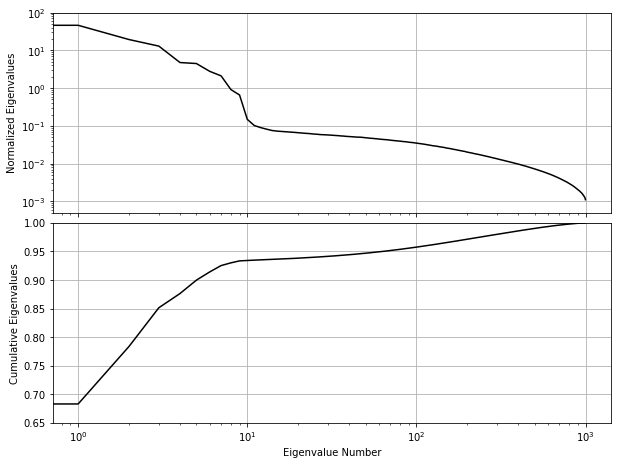

In [6]:
fig = plt.figure(figsize=(10, 7.5))
fig.subplots_adjust(hspace=0.05, bottom=0.12)

ax = fig.add_subplot(211, xscale='log', yscale='log')
ax.grid()
ax.plot(evals, c='k')
ax.set_ylabel('Normalized Eigenvalues')
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_ylim(5E-4, 100)

ax = fig.add_subplot(212, xscale='log')
ax.grid()
ax.semilogx(evals_cs, color='k')
ax.set_xlabel('Eigenvalue Number')
ax.set_ylabel('Cumulative Eigenvalues')
ax.set_ylim(0.65, 1.00)

plt.show()

## Comparing LLE, ISOMAP, UMAP

In [5]:
def get_eigenvalues(X, n_neighbours, n_clusters):
    """ Helper function that will construct a nearest neighbours
    similarity graph from X, then compute a normalised Laplacian for this graph,
    and then calculate the smallest n_clusters eigenvalues.
    
    This is useful for identifying the number of clusters expected
    in the data when using SpectralEmbedding
    """
    K = kneighbors_graph(X, n_neighbors=n_neighbours, include_self=True)

    K = 0.5 * (K + K.T)


    # diagonal matrix
    L, D = csgraph_laplacian(
            K, normed=True, return_diag=True
        )

    L = L.tocoo()
    diag_idx = L.row == L.col
    L.data[diag_idx] = 1
    # If the matrix has a small number of diagonals (as in the
    # case of structured matrices coming from images), the
    # dia format might be best suited for matvec products:
    n_diags = np.unique(L.row - L.col).size
    if n_diags <= 7:
        # 3 or less outer diagonals on each side
        L = L.todia()
    else:
        # csr has the fastest matvec and is thus best suited to
        # arpack
        L = L.tocsr()

    L *= -1
    vals, vecs = eigsh(
        L, k=n_clusters, sigma=1.0, which="LM", tol=1e-5
    )

    # sort these based on the eigenvalues
    vecs = vecs[:,np.argsort(vals)]
    vals = vals[np.argsort(vals)]
    plt.plot(vals)
    
    return vecs, vals


def plot_2d(X, labels, title):
    plt.figure()
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap=plt.cm.jet)
    plt.xlabel('coefficient 1')
    plt.ylabel('coefficient 2')
    plt.title(title)
    
    

def mask_outliers(X):
    BT = neighbors.BallTree(X)
    dist, ind = BT.query(X, 10)
    dist_to_n = dist[:, -1]
    dist_to_n -= dist_to_n.mean()
    std = np.std(dist_to_n)
    flag = (dist_to_n > 0.25 * std)
    print(" - removing {0} outliers for plot".format(flag.sum()))
    return flag

### Isomap

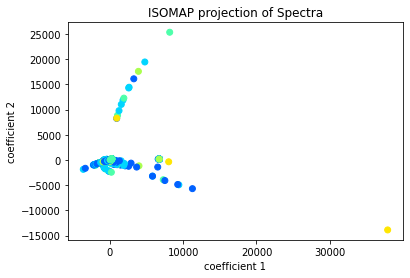

In [6]:
iso = Isomap(n_components=2, n_neighbors=10)

iso.fit(spectra_raw)

ISOMAP_PROJECTION = iso.transform(spectra_raw)

plot_2d(ISOMAP_PROJECTION, y, 'ISOMAP projection of Spectra')

### UMAP


In [336]:
umap_obj = UMAP(
    n_components=2, 
    metric="euclidean",
    n_neighbors=IMPLEMENT_ME, 
    min_dist=IMPLEMENT_ME,
    random_state=random_state
)


UMAP_PROJECTION = IMPLEMENT_ME

plot_2d(UMAP_PROJECTION, y, 'UMAP projection of Spectra')

### Spectral Embedding

In [ ]:
se = SpectralEmbedding(n_components=2, n_neighbors=IMPLEMENT_ME, random_state=random_state) 

SE_PROJECTION = IMPLEMENT_ME

plot_2d(SE_PROJECTION, y, 'SpectralEmbedding projection of Spectra')

### LLE

In [ ]:
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, method='modified', eigen_solver='dense', random_state=random_state) 

LLE_PROJECTION = IMPLEMENT_ME

# Note: the LLE projection has some outliers that can make the plot
# look weird.  Use the following to find the mask to remove the outliers
# for the plot
flag = mask_outliers(LLE_PROJECTION)


plot_2d(LLE_PROJECTION[~flag], y[~flag], 'LLE projection of Spectra')

### Normalise data

In [7]:
scaler = StandardScaler()
scaled_spectra = scaler.fit_transform(spectra_raw)

# Question 1.1

In [8]:
def run_analysis(n_samples):
    times = {}
    # n_points = 10000
    # X, color = datasets.make_s_curve(n_points, random_state=0)
    noise = 0.05
    
    if n_samples == spectra.shape[0]:
        X = scaled_spectra
        labels = y
    else:
        sample_id = random.sample(range(0, 
                              spectra.shape[0]-1), int(n_samples))
        labels = y[sample_id]
        
        X = scaled_spectra[sample_id, :]  
    

    n_neighbors = 10
    n_components = 2

    # Create figure
    fig = plt.figure(figsize=(15, 8))
    fig.suptitle("Manifold Learning with %i points, %i neighbors"
                 % (n_samples, n_neighbors), fontsize=14)

    # Add 3d scatter plot
    ax = fig.add_subplot(251, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels, cmap=plt.cm.Spectral)
    ax.view_init(4, -72)

    # Set-up manifold methods

    methods = OrderedDict()
    
    methods['Modified LLE'] = LocallyLinearEmbedding(n_components=n_components, 
                                                     n_neighbors=n_neighbors, 
                                                     method='modified', eigen_solver='dense', random_state=random_state)

    methods['Isomap'] = Isomap(n_neighbors=n_neighbors,
                                        n_components=n_components)
    methods['SE'] = SpectralEmbedding(n_components=n_components,
                                               n_neighbors=n_neighbors, random_state=random_state)
    
    methods['Umap'] = UMAP(
                                    n_components=n_components, 
                                    metric="euclidean",
                                    n_neighbors=n_neighbors, 
                                    min_dist=0,
                                    random_state=random_state)

    # Plot results
    for i, (label, method) in enumerate(methods.items()):
    
    
        if 'LocallyLinearEmbedding' in str(method):
            t0 = time()
            Y = method.fit_transform(X)
            t1 = time()
            flag = mask_outliers(Y)
            Y = Y[~flag]
            label_y = labels[~flag]
        else :
            t0 = time()
            Y = method.fit_transform(X)
            t1 = time()
            label_y = labels
            
        
        times[label] = t1-t0
        print("%s: %.2g sec" % (label, t1 - t0))
        ax = fig.add_subplot(2, 5, 2 + i + (i > 3))
        ax.scatter(Y[:, 0], Y[:, 1], c=label_y, cmap=plt.cm.Spectral)
        ax.set_title("%s (%.2g sec)" % (label, t1 - t0))
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.axis('tight')

    plt.show()
    return times

2000.0
 - removing 5 outliers for plot
Modified LLE: 2.6 sec
Isomap: 2.6 sec
SE: 0.83 sec
Umap: 13 sec


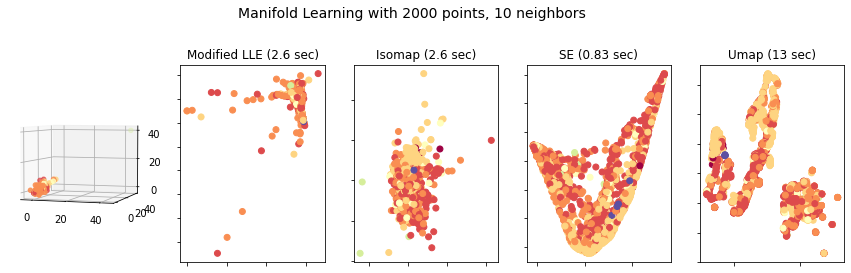

3000.0
 - removing 9 outliers for plot
Modified LLE: 7.6 sec
Isomap: 6.9 sec
SE: 1.5 sec
Umap: 14 sec


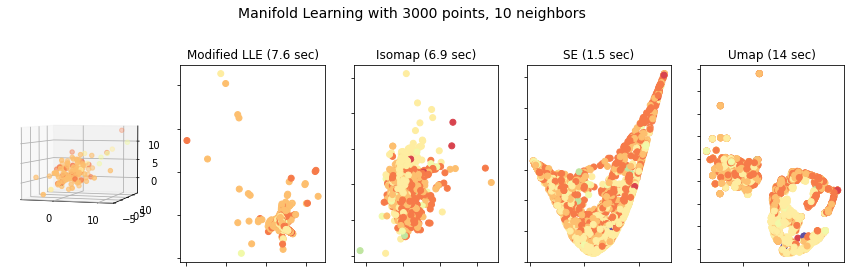

4000
 - removing 5 outliers for plot
Modified LLE: 14 sec
Isomap: 12 sec
SE: 2.5 sec
Umap: 23 sec


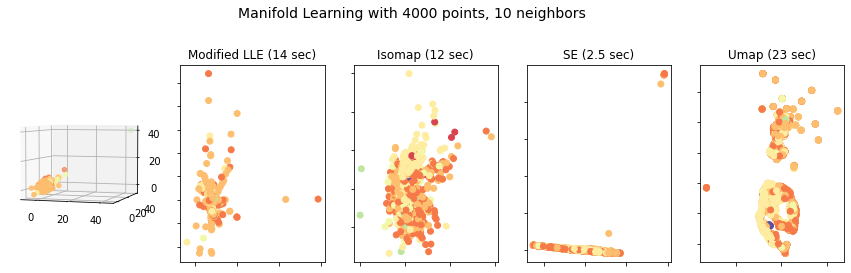

In [9]:
times_all = {}
for sample_size in [scaled_spectra.shape[0]*0.5, scaled_spectra.shape[0]*0.75, scaled_spectra.shape[0]]:
    print(sample_size)
    times_all[sample_size] = run_analysis(sample_size)

In [10]:
pd.DataFrame(times_all)

,2000.0,3000.0,4000.0
Modified LLE,2.612662,7.614584,13.543040
Isomap,2.630041,6.936792,12.003707
SE,0.830673,1.450057,2.546063
Umap,13.045838,13.960044,22.610862


#### Question 1.1.1
* The Modified LLE is not stable throught the different subsets
* The Isomap projection looks stable throughout different subsets provided  
* The SpectralEmbedding is stable throught the different subsets but completly changes on full data
* The UMAP is not stable but the projections have a clear similarity in terms of two seperate clusters formed

#### Question 1.1.2
* From the given results and plots it is clear to see that the Isomap is the most stable from our manifold method

# Question 1.2

In [11]:
def run_analysis(n_neighborz):
    times = {}
        
    X = scaled_spectra
    labels = y
    
    n_neighbors = n_neighborz
    n_components = 2

    # Create figure
    fig = plt.figure(figsize=(15, 8))
    fig.suptitle("Manifold Learning with %i points, %i neighbors"
                 % (4000, n_neighbors), fontsize=14)

    # Add 3d scatter plot
    ax = fig.add_subplot(251, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels, cmap=plt.cm.Spectral)
    ax.view_init(4, -72)

    # Set-up manifold methods

    methods = OrderedDict()
    
    methods['Modified LLE'] = LocallyLinearEmbedding(n_components=n_components, 
                                                     n_neighbors=n_neighbors, 
                                                     method='modified', eigen_solver='dense', random_state=random_state)

    methods['Isomap'] = Isomap(n_neighbors=n_neighbors,
                                        n_components=n_components)
    methods['SE'] = SpectralEmbedding(n_components=n_components,
                                               n_neighbors=n_neighbors, random_state=random_state)
    
    methods['Umap'] = UMAP(
                                    n_components=n_components, 
                                    metric="euclidean",
                                    n_neighbors=n_neighbors, 
                                    min_dist=0,
                                    random_state=random_state)

    # Plot results
    for i, (label, method) in enumerate(methods.items()):
    
    
        if 'LocallyLinearEmbedding' in str(method):
            t0 = time()
            Y = method.fit_transform(X)
            t1 = time()
            flag = mask_outliers(Y)
            Y = Y[~flag]
            label_y = labels[~flag]
        else :
            t0 = time()
            Y = method.fit_transform(X)
            t1 = time()
            label_y = labels
            
        
        times[label] = t1-t0
        print("%s: %.2g sec" % (label, t1 - t0))
        ax = fig.add_subplot(2, 5, 2 + i + (i > 3))
        ax.scatter(Y[:, 0], Y[:, 1], c=label_y, cmap=plt.cm.Spectral)
        ax.set_title("%s (%.2g sec)" % (label, t1 - t0))
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.axis('tight')

    plt.show()
    return times

5
 - removing 33 outliers for plot
Modified LLE: 14 sec
Isomap: 9.3 sec


/home/siyabonga/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


SE: 2.9 sec


/home/siyabonga/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Umap: 20 sec


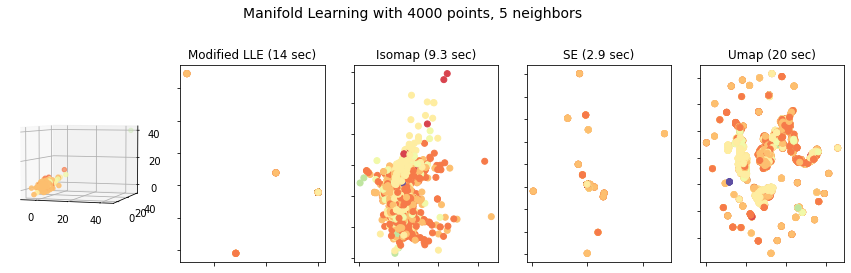

10
 - removing 5 outliers for plot
Modified LLE: 14 sec
Isomap: 12 sec
SE: 2.6 sec
Umap: 22 sec


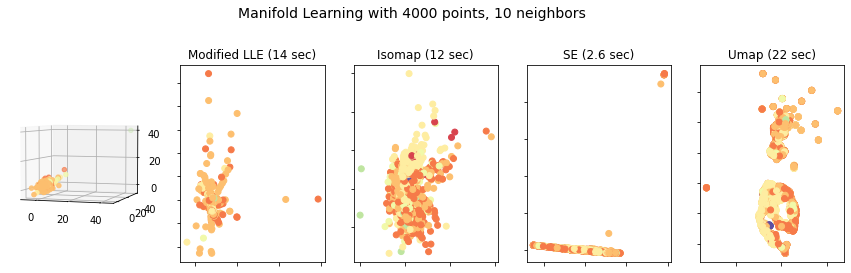

20
 - removing 11 outliers for plot
Modified LLE: 16 sec
Isomap: 15 sec
SE: 2.8 sec
Umap: 24 sec


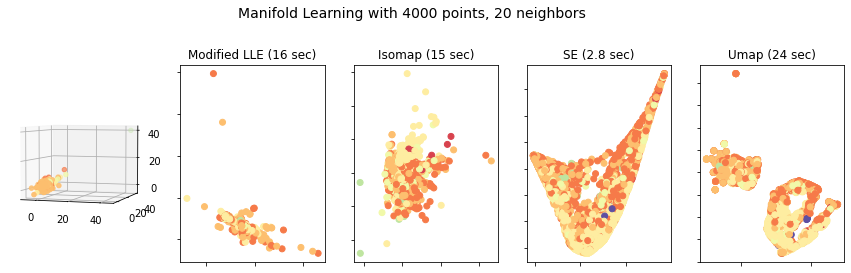

50
 - removing 17 outliers for plot
Modified LLE: 22 sec
Isomap: 23 sec
SE: 3.4 sec
Umap: 27 sec


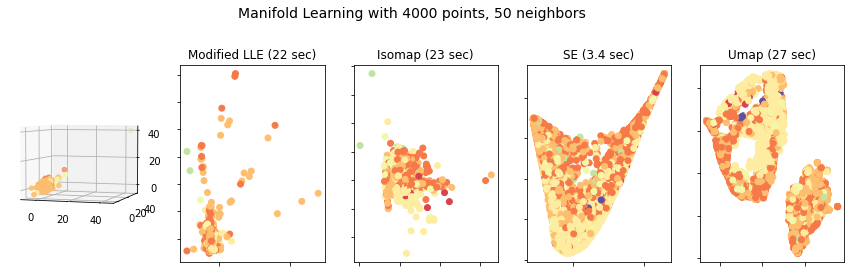

100
 - removing 10 outliers for plot
Modified LLE: 50 sec
Isomap: 35 sec
SE: 6.6 sec
Umap: 30 sec


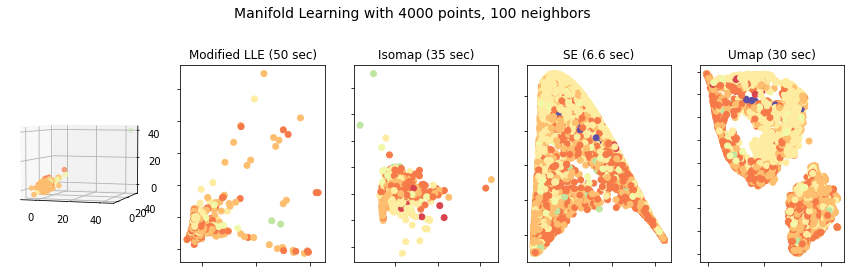

In [12]:
times_all = {}
for neighbour_size in [5, 10, 20, 50, 100]:
    print(neighbour_size)
    times_all[neighbour_size] = run_analysis(neighbour_size)

In [13]:
pd.DataFrame(times_all)

,5,10,20,50,100
Modified LLE,14.129237,13.609778,15.533107,21.774592,49.647349
Isomap,9.316469,11.730905,14.565920,22.653849,35.318809
SE,2.929692,2.646836,2.795650,3.405390,6.580009
Umap,20.352803,21.935811,23.800963,26.748064,30.438866


#### Question 1.2.1
* The modified LLE Change drastically with different number of neighbours. The projection with the lowest number of neighbours seem to have very low points on the projection. As the number of neighbours increases so does the points rin the projection.
* The isomap does not change that much with different number of neighbours. It has a very similar projection throughout different number of neighbours.
* The SpectralEmbedding changes through the different number of neighbours.
* The UMAP at small number of neighbours has no disting shape but from 10 neighbours upwards it has two seperate clusters forming, at very high number of neighbours these clusters looks like they are retaining the same projection form.

#### Question 1.2.2
* The isomap have stable projections throught the different number of neighbours but slightly changes on very high number of neigbours.